In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [28]:
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    """
    Sigmoid activation: 1 / (1 + exp(-x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    """
    Derivative of sigmoid: sigmoid(x) * (1 - sigmoid(x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    sig = sigmoid(x)
    result = sig * (1 - sig)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result


In [29]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, dropout_rate=0.2):
        """
        Initialize the neural network with given layer sizes and learning rate.
        layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.weights = []
        self.biases = []
        self.training = True  # Pour différencier train/inference

        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}
                             A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []
        self.dropout_masks = []

        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            if i < len(self.weights) - 2:
                a = relu(z)
                # Dropout uniquement à l'entraînement
                if self.training and self.dropout_rate > 0:
                    mask = (np.random.rand(*a.shape) > self.dropout_rate).astype(float) / (1.0 - self.dropout_rate)
                    a *= mask
                    self.dropout_masks.append(mask)
                else:
                    self.dropout_masks.append(np.ones_like(a))
                self.activations.append(a)
            else:
                a = sigmoid(z)
                self.activations.append(a)
                self.dropout_masks.append(np.ones_like(a))
        # Dernière couche de sortie
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        output = sigmoid(z)
        self.activations.append(output)
        self.dropout_masks.append(np.ones_like(output))
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy: J = -1/m * sum(y * log(y_pred) + (1-y) * log(1-y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"

        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = (y_pred >= 0.5).astype(int)
        assert predictions.shape == y_true.shape, "Predictions have incorrect shape"
        correct_predictions = np.sum(predictions == y_true)
        accuracy = correct_predictions / y_true.shape[0]
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            assert dA.shape == self.activations[i + 1].shape, "dA has incorrect shape"
            dZ = dA * relu_derivative(self.z_values[i])
            assert dZ.shape == self.activations[i + 1].shape, "dZ has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            assert self.d_weights[i].shape == self.weights[i].shape, f"dW-{i+1} has incorrect shape"
            assert self.d_biases[i].shape == self.biases[i].shape, f"dB-{i+1} has incorrect shape"

            # Ajouter une régularisation L2 aux gradients des poids
            lambda_reg = 0.01
            self.d_weights[i] += lambda_reg * self.weights[i] / m
        assert all(d.shape == w.shape for d, w in zip(self.d_weights, self.weights)), "d_weights have incorrect shapes"
        assert all(d.shape == b.shape for d, b in zip(self.d_biases, self.biases)), "d_biases have incorrect shapes"

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]
            assert self.weights[i].shape == self.d_weights[i].shape, f"Updated weights {i+1} have incorrect shape"
            assert self.biases[i].shape == self.d_biases[i].shape, f"Updated biases {i+1} have incorrect shape"

    def predict_proba(self, X):
        """
        Predict probabilities using the forward pass
        """
        self.training = False
        outputs = self.forward(X)
        assert outputs.shape == (X.shape[0], self.layer_sizes[-1]), "Outputs have incorrect shape"
        return outputs

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        self.training = True
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.ndim == 2 and y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_val_loss = float('inf')
        patience = 10
        wait = 0

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[indices[i:i + batch_size]]
                y_batch = y[indices[i:i + batch_size]]
                assert X_batch.shape[0] == batch_size or (i + batch_size >= X.shape[0] and X_batch.shape[0] < batch_size), "Batch size must match specified batch size"
                assert y_batch.shape[0] == X_batch.shape[0], "y_batch must have the same number of samples as X_batch"
                assert X_batch.shape[1] == self.layer_sizes[0], f"Batch input dimension ({X_batch.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
                assert y_batch.shape[1] == self.layer_sizes[-1], f"Batch output dimension ({y_batch.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculer les pertes et accuracies pour l'entraînement et la validation
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_accuracy = self.compute_accuracy(y, self.predict_proba(X))
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_accuracy = self.compute_accuracy(y_val, self.predict_proba(X_val))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        self.training = False
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = (outputs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions


In [30]:
class AdamNeuralNetwork(NeuralNetwork):
    def __init__(self, layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, dropout_rate=0.2):
        super().__init__(layer_sizes, learning_rate, dropout_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.t = 0

    def backward(self, X, y, outputs):
        super().backward(X, y, outputs)  # gradients are computed as in base class
        self.t += 1
        for i in range(len(self.weights)):
            # Adam update for weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
            m_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            # Adam update for biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)
            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [31]:
data = pd.read_csv(r'C:\Users\A\Desktop\Deep_Learning\diabetes.csv')


In [32]:
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Target variable
assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"
# Reshape y to 2D for compatibility with the neural network
if y.ndim == 1:
    y = y.reshape(-1, 1)

# Standardisation : X = (X - mu) / sigma
X = (X - X.mean(axis=0)) / X.std(axis=0)

# After standardization, before splitting
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 × 0.8 = 0.2
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

# Reshape y arrays if they are 1D
for arr_name in ['y_train', 'y_val', 'y_test']:
    arr = locals()[arr_name]
    if arr.ndim == 1:
        locals()[arr_name] = arr.reshape(-1, 1)

print("Distribution des classes dans y (after SMOTE):", dict(zip(*np.unique(y, return_counts=True))))


Distribution des classes dans y (after SMOTE): {np.int64(0): np.int64(500), np.int64(1): np.int64(500)}


In [33]:
layer_sizes = [X_train.shape[1], 32, 16, 8, 1]  # More layers and neurons
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Cell 7: Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_accuracies = []

print("\nStarting Cross-Validation:")
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]
    # Reshape if needed
    if y_train_cv.ndim == 1:
        y_train_cv = y_train_cv.reshape(-1, 1)
    if y_val_cv.ndim == 1:
        y_val_cv = y_val_cv.reshape(-1, 1)
    nn_cv = NeuralNetwork(layer_sizes, learning_rate=0.01)
    nn_cv.train(X_train_cv, y_train_cv, X_val_cv, y_val_cv, epochs=50, batch_size=32)
    y_pred_cv = nn_cv.predict(X_val_cv)
    acc = nn_cv.compute_accuracy(y_val_cv, y_pred_cv)
    cv_accuracies.append(acc)
    print(f"Fold {fold+1}/{n_splits} - Validation Accuracy: {acc:.4f}")

print(f"\nCross-Validation: Average Accuracy = {np.mean(cv_accuracies):.4f} (+/- {np.std(cv_accuracies):.4f})")


Epoch 0, Train Loss: 0.7360, Val Loss: 0.6902, Train Acc: 0.5050, Val Acc: 0.5200
Epoch 10, Train Loss: 0.7007, Val Loss: 0.6549, Train Acc: 0.6600, Val Acc: 0.7000
Epoch 20, Train Loss: 0.6589, Val Loss: 0.6144, Train Acc: 0.7183, Val Acc: 0.7650
Epoch 30, Train Loss: 0.6148, Val Loss: 0.5689, Train Acc: 0.7583, Val Acc: 0.7850
Epoch 40, Train Loss: 0.5700, Val Loss: 0.5259, Train Acc: 0.7650, Val Acc: 0.7750
Epoch 50, Train Loss: 0.5413, Val Loss: 0.5032, Train Acc: 0.7633, Val Acc: 0.7800
Epoch 60, Train Loss: 0.5246, Val Loss: 0.4965, Train Acc: 0.7717, Val Acc: 0.7650
Epoch 70, Train Loss: 0.5139, Val Loss: 0.4935, Train Acc: 0.7750, Val Acc: 0.7750
Epoch 80, Train Loss: 0.5547, Val Loss: 0.5252, Train Acc: 0.7817, Val Acc: 0.7650
Early stopping at epoch 81

Starting Cross-Validation:
Epoch 0, Train Loss: 0.6971, Val Loss: 0.6937, Train Acc: 0.5225, Val Acc: 0.5350


C:\Users\A\AppData\Local\Temp\ipykernel_21668\1911345600.py:24: RuntimeWarning: overflow encountered in exp
  result = 1 / (1 + np.exp(-x))


Epoch 10, Train Loss: 0.6413, Val Loss: 0.6495, Train Acc: 0.7013, Val Acc: 0.6700
Epoch 20, Train Loss: 0.5876, Val Loss: 0.5969, Train Acc: 0.7488, Val Acc: 0.7250
Epoch 30, Train Loss: 0.5379, Val Loss: 0.5459, Train Acc: 0.7600, Val Acc: 0.7500
Epoch 40, Train Loss: 0.5095, Val Loss: 0.5232, Train Acc: 0.7650, Val Acc: 0.7650
Fold 1/5 - Validation Accuracy: 0.7800
Epoch 0, Train Loss: 0.6971, Val Loss: 0.6918, Train Acc: 0.5225, Val Acc: 0.5200
Epoch 10, Train Loss: 0.6490, Val Loss: 0.6394, Train Acc: 0.6813, Val Acc: 0.7050
Epoch 20, Train Loss: 0.6019, Val Loss: 0.5813, Train Acc: 0.7462, Val Acc: 0.7750
Epoch 30, Train Loss: 0.5520, Val Loss: 0.5238, Train Acc: 0.7575, Val Acc: 0.7850
Epoch 40, Train Loss: 0.5240, Val Loss: 0.4847, Train Acc: 0.7600, Val Acc: 0.7850
Fold 2/5 - Validation Accuracy: 0.7950
Epoch 0, Train Loss: 0.6981, Val Loss: 0.6934, Train Acc: 0.5350, Val Acc: 0.5050
Epoch 10, Train Loss: 0.6420, Val Loss: 0.6503, Train Acc: 0.7037, Val Acc: 0.6550
Epoch 20, T

In [34]:
adam_nn = AdamNeuralNetwork(layer_sizes, learning_rate=0.001, dropout_rate=0.2)
adam_train_losses, adam_val_losses, adam_train_accuracies, adam_val_accuracies = adam_nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)
print("\nAdam optimizer - Test accuracy:", adam_nn.compute_accuracy(y_test, adam_nn.predict(X_test)))



Epoch 0, Train Loss: 0.7319, Val Loss: 0.6799, Train Acc: 0.5600, Val Acc: 0.5750
Epoch 10, Train Loss: 0.5990, Val Loss: 0.5498, Train Acc: 0.7633, Val Acc: 0.7750
Epoch 20, Train Loss: 0.5393, Val Loss: 0.4946, Train Acc: 0.7467, Val Acc: 0.7300
Epoch 30, Train Loss: 0.5169, Val Loss: 0.4919, Train Acc: 0.7600, Val Acc: 0.7750
Early stopping at epoch 33

Adam optimizer - Test accuracy: 0.76



Classification Report (Test set - Standard NN):
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       100
           1       0.74      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

Distribution des classes prédites (Standard NN): {np.int64(0): np.int64(90), np.int64(1): np.int64(110)}


C:\Users\A\AppData\Local\Temp\ipykernel_21668\1911345600.py:24: RuntimeWarning: overflow encountered in exp
  result = 1 / (1 + np.exp(-x))


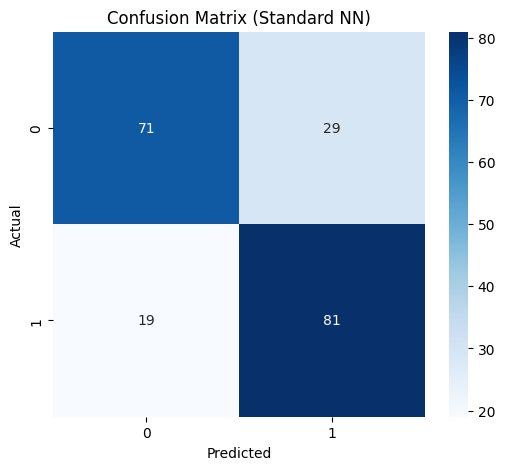

In [35]:
y_pred = nn.predict(X_test)
print("\nClassification Report (Test set - Standard NN):")
print(classification_report(y_test, y_pred))

# Check distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Distribution des classes prédites (Standard NN):", dict(zip(unique.flatten(), counts)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Standard NN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


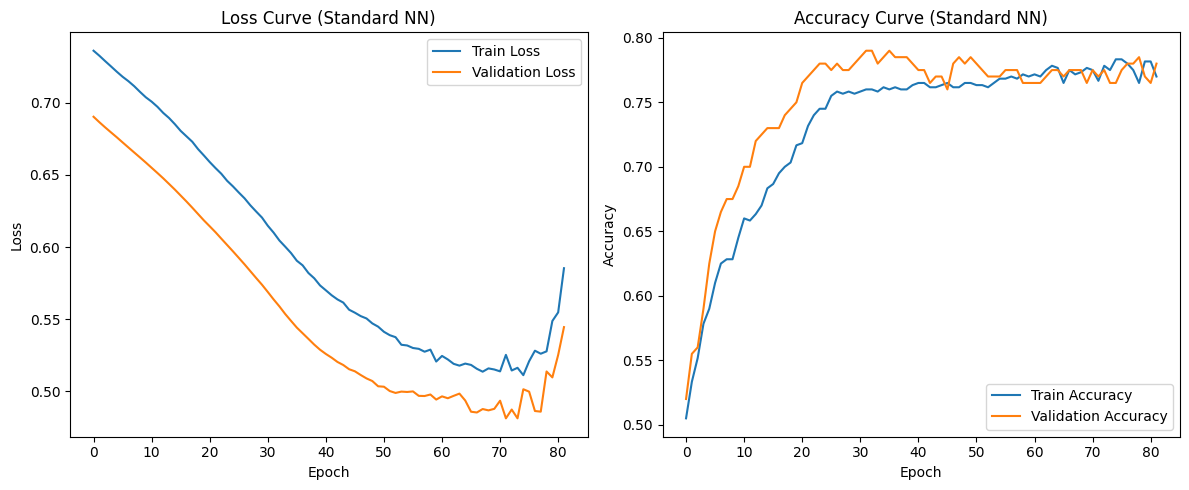

<Figure size 640x480 with 0 Axes>

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Curve
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve (Standard NN)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy Curve
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (Standard NN)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()
plt.savefig('curves.png')

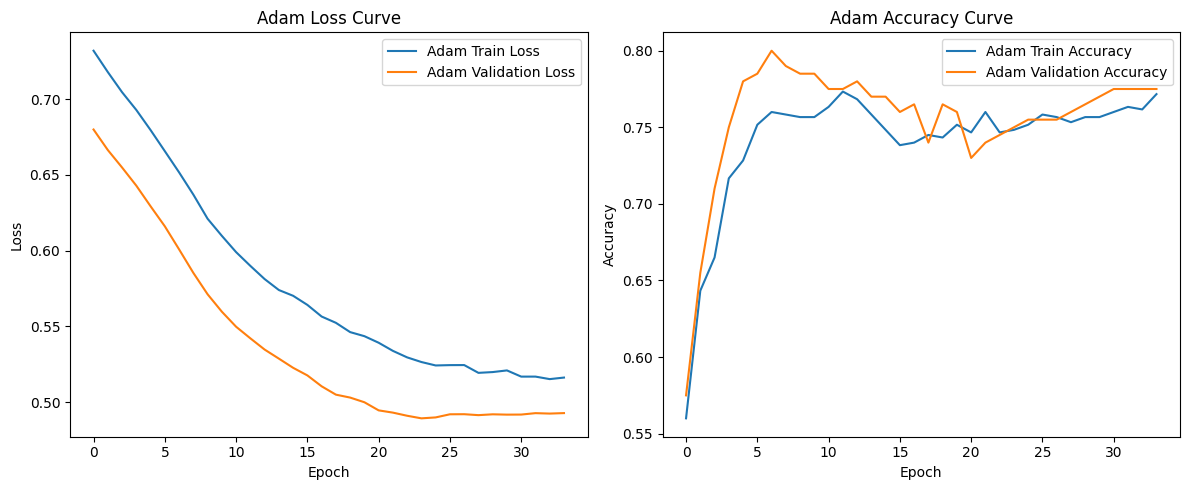

<Figure size 640x480 with 0 Axes>

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(adam_train_losses, label='Adam Train Loss')
ax1.plot(adam_val_losses, label='Adam Validation Loss')
ax1.set_title('Adam Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(adam_train_accuracies, label='Adam Train Accuracy')
ax2.plot(adam_val_accuracies, label='Adam Validation Accuracy')
ax2.set_title('Adam Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()
plt.savefig('adam_curves.png')

F1-score (Standard NN): 0.7714285714285715
AUC-ROC (Standard NN): 0.7647499999999999


C:\Users\A\AppData\Local\Temp\ipykernel_21668\1911345600.py:24: RuntimeWarning: overflow encountered in exp
  result = 1 / (1 + np.exp(-x))


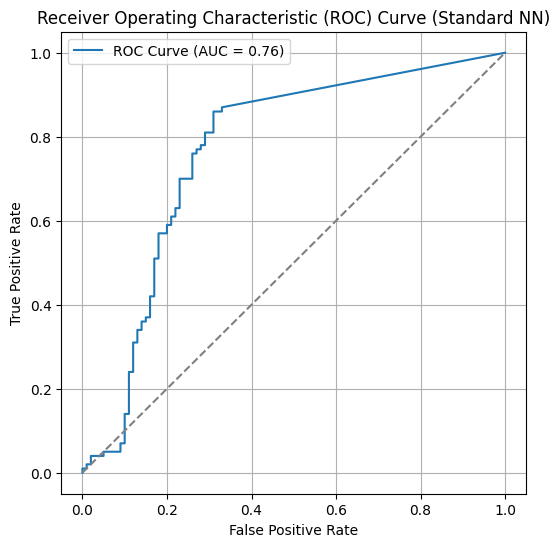

<Figure size 640x480 with 0 Axes>

In [38]:
y_pred_proba = nn.predict_proba(X_test)
print("F1-score (Standard NN):", f1_score(y_test, y_pred))
print("AUC-ROC (Standard NN):", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Standard NN)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('roc_curve.png')


In [39]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'],
    'Value': [
        nn.compute_accuracy(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_proba)
    ]
})
print("\nEvaluation Summary (Standard NN):\n", metrics_df)


Evaluation Summary (Standard NN):
       Metric     Value
0   Accuracy  0.760000
1  Precision  0.736364
2     Recall  0.810000
3   F1-score  0.771429
4    AUC-ROC  0.764750
